<a href="https://colab.research.google.com/github/meghamkpatel/Skunks_Skool/blob/main/INFO_6105/Report/Zomato_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Northeastern University: INFO6105 Data Science and Engineering Methods 
## Zomato_EDA

*Data Analysis*

Megha Patel

# Abstract

Zomato is an Indian multinational restaurant aggregator and food delivery company. 

Zomato provides information, menus and user-reviews of restaurants as well as food delivery options from partner restaurants in select cities. 
This dataset is comprised of information of food restraunts in Banglaore working with Zomato.

Reference: https://www.kaggle.com/datasets/pranavuikey/zomato-eda

The aim of the notebook is to check the quality of the data, determine what features are important, create predictive models with AutoML, and interpret each model. This notebook will step through each node of the data engineering process(see image below).

##The Data:
* Meal Type (categorical): Type of service - Buffet, Cafes, Delivery, Desserts, Dine-out, Drinks & nightlife, Pubs and bars
* Rating (numeric): Rating of restaurant out of 4 stars -**the dependent variable**
* Number of Votes (numeric): Number of votes given by app users to a restaurant
* Online Ordering? (categorical): Does the restaurant offer online ordering (yes or no)?
* Reservation Needed? (categorical): Does the restaurant require reservations (yes or no)?
* City (categorical): Location of the restaurant
* Restaurant Type (categorical): Does the restaurant require reservations (yes or no)?
* Cuisines (categorical): Type of cuisine - Middle Eastern, Asian Fusion, Italian, North Indian, Cafe, Continental, Fast Food, American, South Indian, Asian, Street Food, African, Mexican
* Cost (numeric): average cost in Rupees  

During this analysis, we are classifying the rating a restaurant might get based on its features. By analyzing each feature, we see that number of votes has the biggest impact on ratings. In addition, the numerical variables show that the data is non-linear, demonstrating that prediction of ratings is a non-linear problem. Using AutoML, we see that Gradient Boosting Machines proves to outperform all other models. We use SHAP values to understand how each feature impacts each restaurant in detail.

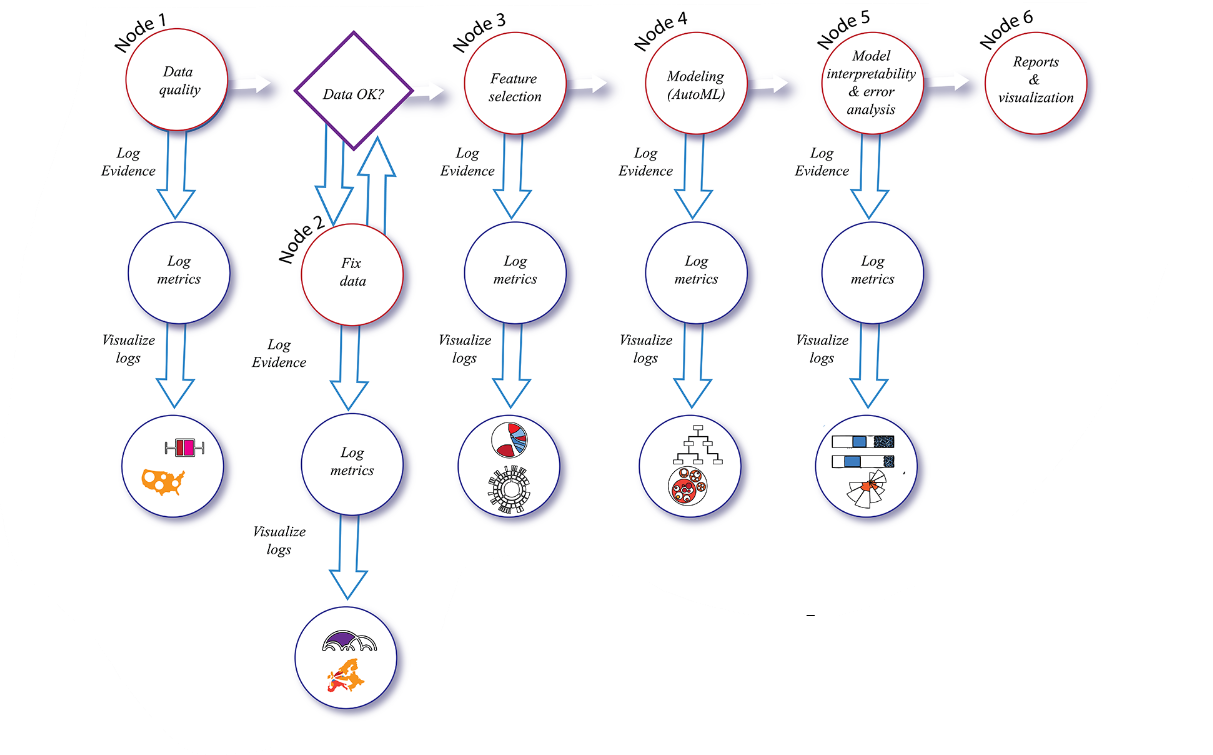

#Node 1: Data Quality

_________________________________________________________
###Getting our data

This dataset contains 51717 data values which is above GitHub's threshold of .csv files. Accordingly, we pull in the kaggle dataset directly using the kaggle library and my kaggle credentials.

In [1]:
#installing dependencies
!pip install eli5
!pip install shap
! pip install -q kaggle
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 10.6 MB/s 
     |████████████████████████████████| 133 kB 30.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=6670006a44f42ca450e764063257f4d29a7b8f1dd7981de6890270b71aa4d615
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incomp

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pprint
import operator
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import math
import shap

In [3]:
#making a directory for kaggle api
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#downloading and reading the zomato dataset
! kaggle datasets list -s zomato # searching through kaggle with keyword 'zomato'
! kaggle datasets download -d pranavuikey/zomato-eda
!unzip zomato-eda.zip

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
himanshupoddar/zomato-bangalore-restaurants                  Zomato Bangalore Restaurants                        89MB  2019-03-31 09:48:43          47918       1181  1.0              
shrutimehta/zomato-restaurants-data                          Zomato Restaurants Data                              5MB  2018-03-13 04:56:25          45833        626  0.7941176        
rishikeshkonapure/zomato                                     Zomato                                              89MB  2022-10-29 06:56:33           1682         49  1.0              
batjoker/zomato-restaurants-hyderabad                        Zomato Restaurants 

In [5]:
#Viewing data in the file 
data = pd.read_csv("zomato.csv")
data.shape
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


Additionally, I have sampled a 2000 random points as an alternative for a local file and commented out the code to change the input to that file

In [230]:
data = pd.read_csv('zomatoSample.csv')

#Node 2: Fix data

##Cleaning Up Data


The dataset contains inconsistant values and missing data so it will require cleaning up. The significance of the predictors is investigated and it appears that of the 16 independent variables,  9 are significant, these results can be used to further optimize the model for predicting the best restaurants depending on a customer's need. Additionally, we must clean the dataset for this assignment to prevent any errors that would limit the full potential of AutoML.

###Dropping columns 

The columns phone, dish_liked, url, menu_item, and reviews_list help identify the restaurant but do not add characteristics to the dataset so we can drop them. 

In [129]:
data.drop(['url','address','phone','menu_item','dish_liked','reviews_list',"listed_in(city)"],axis = 1,inplace=True)
data.head(3)

,Unnamed: 0,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
0,17707,A 1 Pizza and Food,Yes,No,2.8/5,211,Old Airport Road,Delivery,"Pizza, Chinese, North Indian",300,Delivery
1,29075,Dash In,No,No,3.1 /5,53,BTM,Casual Dining,"North Indian, Chinese, Kerala",600,Dine-out
2,31060,Indigo XP,No,No,4.2 /5,2369,Koramangala 5th Block,Pub,"Finger Food, Continental, Asian, North Indian","1,400",Dine-out


#### Renaming Column Headers
To better understand the data, let's first rename our column headers with appropriate units and descripter language. 

In [130]:
data.rename(columns={'name':'Restaurant','online_order': 'Online Ordering?', 'book_table':'Reservation Needed?','votes': 'Number of Votes','location':'City','rest_type': 'Restaurant Type', 'cuisines': 'Cuisines','rate':'Rating','approx_cost(for two people)':'Cost(Rupees)','listed_in(type)':'Meal Type'},inplace=True)
data.head(3)

,Unnamed: 0,Restaurant,Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
0,17707,A 1 Pizza and Food,Yes,No,2.8/5,211,Old Airport Road,Delivery,"Pizza, Chinese, North Indian",300,Delivery
1,29075,Dash In,No,No,3.1 /5,53,BTM,Casual Dining,"North Indian, Chinese, Kerala",600,Dine-out
2,31060,Indigo XP,No,No,4.2 /5,2369,Koramangala 5th Block,Pub,"Finger Food, Continental, Asian, North Indian","1,400",Dine-out


###Missing Data

Imputing Missing Data:
We have three methods for imputing missing data. Using the median, dropping, and using machine learning. 

In [131]:
missing_list = data.columns[data.isna().any()].tolist() 
missing_count = []      
for i in missing_list:
  missing_count.append(sum(pd.isnull(data[str(i)])))

d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
Missing_DF = pd.DataFrame(d)
Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
Missing_DF

,Missing_Column,Missing_Values,%_Missing
0,Rating,301,15.05
1,City,2,0.10
2,Restaurant Type,13,0.65
3,Cuisines,4,0.20
4,Cost(Rupees),21,1.05


We see that most of our missing data is Rating. The median method in this case would not make sense for null values because rating for a restaurant should not be effected by the rest of the data. For example, a new restaurant that did not get the chance pass the inspection exam with rating "NEW" should not be replaced by a 3 star rating when there is an equal chance the restaurant could be of lower or higher quality. We could potentially explore Machine Learning but for the purposes of the training data we can justify using the dropping method for columns that are missing 5% or less of data since it is a very small percentage of missing data.
Note: I chose to drop NaN but other notebooks chose to use the mean to replace empty values.

In [132]:
data = data.dropna()
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1674 non-null   int64 
 1   Restaurant           1674 non-null   object
 2   Online Ordering?     1674 non-null   object
 3   Reservation Needed?  1674 non-null   object
 4   Rating               1674 non-null   object
 5   Number of Votes      1674 non-null   int64 
 6   City                 1674 non-null   object
 7   Restaurant Type      1674 non-null   object
 8   Cuisines             1674 non-null   object
 9   Cost(Rupees)         1674 non-null   object
 10  Meal Type            1674 non-null   object
dtypes: int64(2), object(9)
memory usage: 156.9+ KB


In [133]:
data.isnull().sum()

Unnamed: 0             0
Restaurant             0
Online Ordering?       0
Reservation Needed?    0
Rating                 0
Number of Votes        0
City                   0
Restaurant Type        0
Cuisines               0
Cost(Rupees)           0
Meal Type              0
dtype: int64

#### Remove Duplicates
In case we have any duplicated rows, we remove duplicates. This is ensure there is no bias with repeating restaurants.

In [134]:
data.drop_duplicates(inplace=True)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1674 non-null   int64 
 1   Restaurant           1674 non-null   object
 2   Online Ordering?     1674 non-null   object
 3   Reservation Needed?  1674 non-null   object
 4   Rating               1674 non-null   object
 5   Number of Votes      1674 non-null   int64 
 6   City                 1674 non-null   object
 7   Restaurant Type      1674 non-null   object
 8   Cuisines             1674 non-null   object
 9   Cost(Rupees)         1674 non-null   object
 10  Meal Type            1674 non-null   object
dtypes: int64(2), object(9)
memory usage: 156.9+ KB


### Clean up individual columns
Finally, we should check each variable and clean out data that does not make sense. This can either mean standardizing what "null" means in that context or removing random characters from changing data formats from object to integer



##### *Rating*

In [135]:
data['Rating'].unique()

array(['2.8/5', '3.1 /5', '4.2 /5', 'NEW', '3.8 /5', '4.1/5', '3.4 /5',
       '4.0 /5', '4.3/5', '3.1/5', '2.2/5', '3.9 /5', '4.4/5', '3.3 /5',
       '3.3/5', '3.5/5', '3.8/5', '3.5 /5', '2.9 /5', '2.7 /5', '4.0/5',
       '4.3 /5', '3.4/5', '3.9/5', '4.1 /5', '3.6/5', '3.7 /5', '3.2 /5',
       '4.5/5', '3.6 /5', '3.2/5', '4.6/5', '4.2/5', '3.0/5', '3.7/5',
       '2.9/5', '4.5 /5', '4.4 /5', '2.6 /5', '2.1 /5', '2.6/5', '3.0 /5',
       '4.7 /5', '4.6 /5', '2.2 /5', '2.7/5', '-', '2.8 /5', '2.5 /5',
       '4.7/5', '2.4 /5', '4.9 /5', '2.4/5', '2.5/5'], dtype=object)

By displaying all unique values from the Rating column, we see that some entries contain "NEW", "nan", and "-" representing no ratings. We can standardize empty values to be nan. We also see that the Rating field contains strings of a floating number out of 5. To prepare for analyzing our data, we will extract the rating, setting the variable to be of type float. 

In [136]:
def clean(value):
    if value=='NEW' or value=='-':
        return np.nan
    else:
        value=str(value).split('/')
        value=value[0]
        return float(value)
    
data['Rating']=data['Rating'].apply(clean)
data['Rating'].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1674 non-null   int64  
 1   Restaurant           1674 non-null   object 
 2   Online Ordering?     1674 non-null   object 
 3   Reservation Needed?  1674 non-null   object 
 4   Rating               1578 non-null   float64
 5   Number of Votes      1674 non-null   int64  
 6   City                 1674 non-null   object 
 7   Restaurant Type      1674 non-null   object 
 8   Cuisines             1674 non-null   object 
 9   Cost(Rupees)         1674 non-null   object 
 10  Meal Type            1674 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 156.9+ KB


In [137]:
data = data.dropna(subset=["Rating"])
data['Rating'] = [round(x) for x in data['Rating']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [138]:
data['Rating'].unique()

array([3, 4, 2, 5])

##### *Location*


In [139]:
data['City'].unique()

array(['Old Airport Road', 'BTM', 'Koramangala 5th Block',
       'Sarjapur Road', 'Shanti Nagar', 'Ejipura', 'Hennur',
       'Basaveshwara Nagar', 'Kammanahalli', 'Brigade Road',
       'Bannerghatta Road', 'Jayanagar', 'Indiranagar', 'Domlur',
       'Electronic City', 'Whitefield', 'Banaswadi',
       'Koramangala 6th Block', 'Frazer Town', 'Koramangala 4th Block',
       'Cunningham Road', 'Koramangala 7th Block', 'Marathahalli',
       'Malleshwaram', 'HSR', 'Koramangala 2nd Block', 'Residency Road',
       'Infantry Road', 'Ulsoor', 'New BEL Road', 'St. Marks Road',
       'Brookefield', 'JP Nagar', 'Banashankari', 'Sahakara Nagar',
       'Nagawara', 'Richmond Road', 'Koramangala 3rd Block', 'Bellandur',
       'Basavanagudi', 'MG Road', 'Rajajinagar', 'Koramangala 8th Block',
       'Koramangala 1st Block', 'Jeevan Bhima Nagar', 'Commercial Street',
       'Thippasandra', 'Church Street', 'Kalyan Nagar', 'Shivajinagar',
       'Rammurthy Nagar', 'Sadashiv Nagar', 'Wilson Garde

In [140]:
data['City'].value_counts(ascending=False)

BTM                      150
Koramangala 5th Block     80
HSR                       77
JP Nagar                  71
Jayanagar                 71
                        ... 
Sanjay Nagar               1
Sankey Road                1
Hosur Road                 1
Old Madras Road            1
Central Bangalore          1
Name: City, Length: 75, dtype: int64

Looking at the breakdown of cities we see no typos or errors and can proceed.

##### *Cost*


In [141]:
data['Cost(Rupees)'].unique()

array(['300', '600', '1,400', '200', '400', '1,200', '500', '550',
       '1,300', '250', '1,000', '1,800', '350', '150', '800', '650',
       '2,000', '1,600', '1,500', '2,200', '100', '900', '700', '450',
       '750', '1,100', '850', '1,900', '2,100', '1,350', '4,000', '1,700',
       '2,800', '1,050', '3,000', '2,500', '180', '70', '3,400', '950',
       '2,400', '4,100', '130'], dtype=object)

Examining the unique values of Cost, we can see that the cost is stored as text with type object. We can correct the type to integer so that we can later model the variables.





In [142]:
data = data.dropna()

In [143]:
def money(value):
    value=str(value)
    if ',' in value:
        value=value.replace(',','')
        return int(value)
    else:
        return int(value)

data['Cost(Rupees)']=data['Cost(Rupees)'].apply(money)

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1578 non-null   int64 
 1   Restaurant           1578 non-null   object
 2   Online Ordering?     1578 non-null   object
 3   Reservation Needed?  1578 non-null   object
 4   Rating               1578 non-null   int64 
 5   Number of Votes      1578 non-null   int64 
 6   City                 1578 non-null   object
 7   Restaurant Type      1578 non-null   object
 8   Cuisines             1578 non-null   object
 9   Cost(Rupees)         1578 non-null   int64 
 10  Meal Type            1578 non-null   object
dtypes: int64(4), object(7)
memory usage: 147.9+ KB


##### *Booking*


In [145]:
data['Reservation Needed?'].unique()

array(['No', 'Yes'], dtype=object)

Booking has no typos so we can proceed.

##### *Online Order*


In [146]:
data['Online Ordering?'].unique()

array(['Yes', 'No'], dtype=object)

Online Ordering has no typos so we can proceed.

##### *Restaurant Type*


In [147]:
data['Restaurant Type'].unique()

array(['Delivery', 'Casual Dining', 'Pub', 'Beverage Shop, Quick Bites',
       'Quick Bites', 'Bar', 'Cafe', 'Bar, Casual Dining',
       'Casual Dining, Pub', 'Quick Bites, Bakery', 'Food Court',
       'Bar, Quick Bites', 'Lounge', 'Kiosk', 'Dessert Parlor',
       'Cafe, Casual Dining', 'Casual Dining, Bar', 'Beverage Shop',
       'Bakery', 'Bakery, Quick Bites', 'Quick Bites, Dessert Parlor',
       'Quick Bites, Mess', 'Pub, Casual Dining', 'Dessert Parlor, Cafe',
       'Bakery, Cafe', 'Microbrewery, Casual Dining',
       'Casual Dining, Cafe', 'Sweet Shop, Quick Bites', 'Sweet Shop',
       'Dessert Parlor, Quick Bites', 'Bakery, Dessert Parlor',
       'Takeaway, Delivery', 'Dessert Parlor, Beverage Shop', 'Pub, Cafe',
       'Dessert Parlor, Bakery', 'Casual Dining, Microbrewery',
       'Fine Dining', 'Cafe, Quick Bites', 'Pub, Bar',
       'Quick Bites, Cafe', 'Bhojanalya', 'Food Truck', 'Lounge, Cafe',
       'Food Court, Quick Bites', 'Cafe, Dessert Parlor', 'Mess',
   

In [148]:
data['Restaurant Type'].value_counts(ascending=False)

Quick Bites             534
Casual Dining           372
Cafe                    133
Dessert Parlor           80
Delivery                 48
                       ... 
Pub, Bar                  1
Microbrewery              1
Bhojanalya                1
Quick Bites, Cafe         1
Lounge, Microbrewery      1
Name: Restaurant Type, Length: 63, dtype: int64

The Restaurant type has lots of values with multiple values for one restaurant. We can simplify the types to general group for better analysis.

In [149]:
def typeSimplify(value):
    value = str(value)
    if 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value:
        return 'Dessert'
    elif 'Quick Bites' in value:
      return 'Quick Bites'
    elif 'Bar' in value or 'Microbrewery' in value:
      return 'Bar'
    elif 'Bakery' in value:
      return 'Bakery'
    elif 'Casual Dining' in value:
      return 'Casual Dining'
    elif 'Fine Dining' in value:
      return 'Fine Dining'
    elif 'Food Court' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value:
      return 'North Indian'
    elif 'South Indian' in value:
      return 'South Indian'
    else:
        return value
    
data['Restaurant Type']=data['Restaurant Type'].apply(typeSimplify)
data['Restaurant Type'].head(10)

0          Delivery
1     Casual Dining
2               Pub
4       Quick Bites
5       Quick Bites
6               Bar
9       Quick Bites
10             Cafe
11      Quick Bites
15      Quick Bites
Name: Restaurant Type, dtype: object

In [150]:
data['Restaurant Type'].unique()

array(['Delivery', 'Casual Dining', 'Pub', 'Quick Bites', 'Bar', 'Cafe',
       'Street Food', 'Lounge', 'Kiosk', 'Dessert', 'Beverage Shop',
       'Bakery', 'Takeaway, Delivery', 'Fine Dining', 'Bhojanalya',
       'Food Truck', 'Mess', 'Takeaway', 'Club'], dtype=object)

In [151]:
data['Restaurant Type'].isnull().sum()

0

##### *Meal Type*


In [152]:
data['Meal Type'].unique()

array(['Delivery', 'Dine-out', 'Drinks & nightlife', 'Pubs and bars',
       'Cafes', 'Buffet', 'Desserts'], dtype=object)

In [153]:
data['Meal Type'].value_counts()

Delivery              747
Dine-out              569
Desserts              106
Cafes                  56
Drinks & nightlife     48
Buffet                 27
Pubs and bars          25
Name: Meal Type, dtype: int64

Meal Type has no typos so we can proceed.

##### *Cuisines*


In [154]:
data['Cuisines'].unique()

array(['Pizza, Chinese, North Indian', 'North Indian, Chinese, Kerala',
       'Finger Food, Continental, Asian, North Indian',
       'Beverages, Fast Food, Burger',
       'South Indian, North Indian, Chinese',
       'Continental, North Indian, Chinese', 'North Indian',
       'Cafe, Continental, American, Beverages', 'Biryani',
       'Naga, Goan, Seafood, Chinese', 'Continental, North Indian',
       'Andhra', 'South Indian', 'Mangalorean, Seafood, South Indian',
       'Modern Indian', 'Chinese, Mangalorean, North Indian',
       'Andhra, Chinese, Continental', 'Cafe', 'Continental',
       'North Indian, Chinese', 'Cafe, Burger',
       'North Indian, Chinese, Assamese', 'North Indian, Street Food',
       'Fast Food, Bakery', 'Pizza', 'Chinese', 'Chinese, Momos',
       'Continental, Chinese', 'Finger Food', 'Street Food, Rolls',
       'Desserts', 'Healthy Food, North Indian, Thai',
       'Healthy Food, North Indian, South Indian',
       'Cafe, Burger, Italian, Fast Food', '

In [155]:
data['Cuisines'].value_counts()

North Indian, Chinese                                 77
North Indian                                          67
South Indian                                          42
South Indian, North Indian, Chinese                   26
Biryani                                               24
                                                      ..
Continental, Asian, Italian, North Indian              1
Steak, Continental, American, Italian, Salad, Cafe     1
Chinese, Vietnamese, Momos, Thai                       1
Arabian, Fast Food                                     1
Cafe, Pizza, Fast Food, Beverages                      1
Name: Cuisines, Length: 698, dtype: int64

Cuisines have multiple values for one restaurant with repeating keywords but they show has different categories. We can simplify this to general groups for better analysis. 

In [156]:
data['Cuisines'].isnull().sum()

0

In [157]:
def cuisineSimplify(value):
    value = str(value)
    if 'Italian' in value or 'Pizza' in value:
        return 'Italian'
    elif 'African' in value:
      return 'African'
    elif 'Continental' in value:
      return 'Continental'
    elif "Mughlai" in value or 'Middle Eastern' in value or 'Biryani' in value or 'Arabian' in value or 'Turkish' in value:
      return 'Middle Eastern'
    elif 'Burger' in value or 'American' in value or 'Salad' in value or 'Sandwich' in value:
      return 'American'
    elif 'Indian' in value and 'Chinese' in value:
      return 'Asian Fusion'
    elif 'Thai' in value or 'Japanese' in value or 'Asian' in value or 'Chinese' in value or 'Tibetan' in value or 'Momo' in value:
      return 'Asian'
    elif 'Mexican' in value:
      return 'Mexican'
    elif 'Street Food' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value or 'Rajasthani' in value or "Gujarati" in value or 'Bengali' in value:
      return 'North Indian'
    elif 'South Indian' in value or 'Kerala' in value or 'Bengali' in value or 'Andhra' in value or 'Maharashtrian':
      return 'South Indian'
    elif 'Mediterranean' in value:
      return 'Mediterranean'
    elif 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value or 'Mithai' in value:
      return 'Dessert'
    elif 'Cafe' in value:
      return 'Cafe'
    else:
        return value
    
data['Cuisines']=data['Cuisines'].apply(cuisineSimplify)
data['Cuisines'].head(10)


0            Italian
1       Asian Fusion
2        Continental
4           American
5       Asian Fusion
6        Continental
9       North Indian
10       Continental
11    Middle Eastern
15             Asian
Name: Cuisines, dtype: object

In [158]:
data['Cuisines'].unique()

array(['Italian', 'Asian Fusion', 'Continental', 'American',
       'North Indian', 'Middle Eastern', 'Asian', 'South Indian', 'Cafe',
       'Street Food', 'Fast Food', 'African', 'Mexican'], dtype=object)

##### *Restaurant*

In [159]:
data.drop(['Restaurant'],axis = 1,inplace=True)

##### *Number of Votes*

In [160]:
data = data.dropna(subset=['Number of Votes'])

In [161]:
data['Number of Votes'].unique()

array([ 211,   53, 2369,    7,   20,   73,   98,   77, 2658,  178,  187,
        143, 1865,    4,    6,  104,   38,   65,   21,  232,  325,   70,
        632,  268,  103, 1203,    8,  656,   16,  457,   12,   54,   95,
        339, 1104,   83,  217,   55,  205, 2781,  383,  119,   14,   24,
       1218, 1082,  297,   51,  450,   29,  177,   27,  675,   41, 3842,
         30,   13,    5,    9,   46,  796,  231,  409,  107,   34,  331,
        533,  167,   22,  739,  272,   15,  733,  239,  122,   48,  218,
         17,  259,   31,  345,  136,  690,  373,  815,  911,  256,  481,
         43,  454,  270, 2075,  261,  166,   92,  382, 1408,   78,  553,
        279,   76,  201,  851,   18,  615,  974, 1007,  289,  145,  691,
        660, 1541,   97,   42,  163,  243, 1730,  127,  631,   32,   91,
       1963,  378,  116,   56,  918,   61,  327,  827,   47, 1098,   19,
        929,   59,  121,   58,  314,  117,   26,  133,   37,  294, 1341,
        148,  109,   68,   84,  542, 3214, 1244,  3

In [162]:
ALOT = 1e6
data['Number of Votes'] = [max(min(x, ALOT), -ALOT) for x in data['Number of Votes']]

#Node 3: Feature Selection

During feature selection, we will check the quality of the data and determine which features are important. We will use statistical methods like p-value, t-statistics and visualization techniques like histogram, Q-Q plot, scatter plot, box-plot of python's matplotlib and seaborn library to answer below questions about the dataset:
* Which independent variables are useful to predict a target (dependent variable)?
* Which independent variables have missing data? How much
* Do the training and test sets have the same data?
* In the predictor variables independent of all the other predictor variables?
* Which predictor variables are the most important?
* Do the ranges of the predictor variables make sense?
* What are the distributions of the predictor variables?

##Data transforming

Now that our dataset is cleaned up, let us standardize the data to compare data in the same unit set. Standardizing data is good practice to define how data should be formatted, eliminating extraneous data, and identifying data errors/multicollinearity. In this assignment, we encode the categorical features and impute the numerical features.

In [163]:
data = data.dropna()

In [164]:
data.replace([np.inf, -np.inf], 0, inplace=True)

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1578 non-null   int64 
 1   Online Ordering?     1578 non-null   object
 2   Reservation Needed?  1578 non-null   object
 3   Rating               1578 non-null   int64 
 4   Number of Votes      1578 non-null   int64 
 5   City                 1578 non-null   object
 6   Restaurant Type      1578 non-null   object
 7   Cuisines             1578 non-null   object
 8   Cost(Rupees)         1578 non-null   int64 
 9   Meal Type            1578 non-null   object
dtypes: int64(4), object(6)
memory usage: 135.6+ KB


In [166]:
data_clean = data #making a copy so we don't lose all that progress!

In [167]:
data_clean['Reservation Needed?'] = data_clean['Reservation Needed?'].map({'Yes': 1, 'No': 0})

We can convert our catagorical variables to numerical ones by creating a new column for each group with a binary value of 1 if that value belongs to that entry (0 if not).

In [168]:
data_clean['Online Ordering?'] = data_clean['Online Ordering?'].map({'Yes': 1, 'No': 0})

In [169]:
from sklearn.model_selection import  train_test_split
import statsmodels.api as sm

X = data_clean.drop(['Rating'],axis=1)
Y = data_clean['Rating']

catagorical_features = ['City', 'Restaurant Type', 'Cuisines', 'Meal Type']
numerical_features = [c for c in X.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

data_clean = data_clean.dropna(subset=['Rating'])

#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%
X_t, X_test, y_t, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

preprocessed_lin_X_train = mapper.fit_transform(X_train)
preprocessed_lin_X_train = sm.add_constant(preprocessed_lin_X_train)


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


##Feature Analysis

Based on the QQ Plots for the numeric variables, we see that the data is skewed and non-linear. We can predict that in AutoML, we are less likely to see linear models.

invalid value encountered in true_divide


<Figure size 576x360 with 0 Axes>

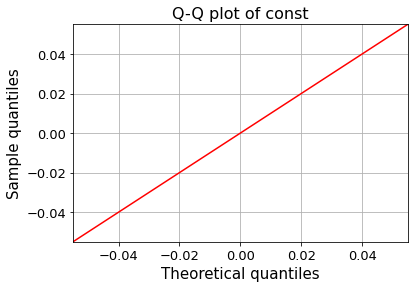

<Figure size 576x360 with 0 Axes>

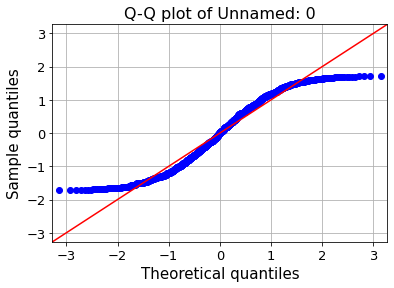

<Figure size 576x360 with 0 Axes>

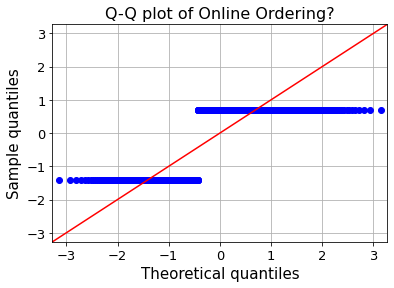

<Figure size 576x360 with 0 Axes>

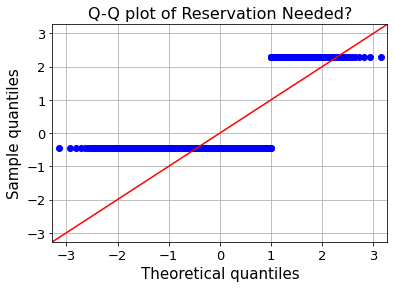

<Figure size 576x360 with 0 Axes>

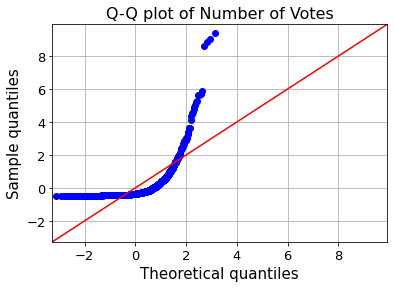

<Figure size 576x360 with 0 Axes>

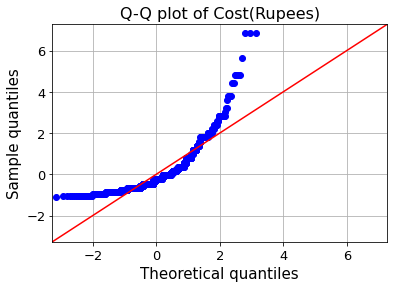

<Figure size 576x360 with 0 Axes>

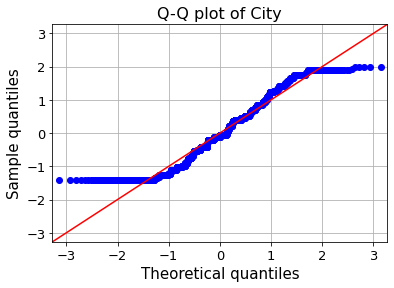

<Figure size 576x360 with 0 Axes>

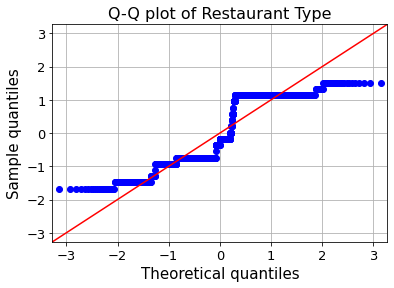

<Figure size 576x360 with 0 Axes>

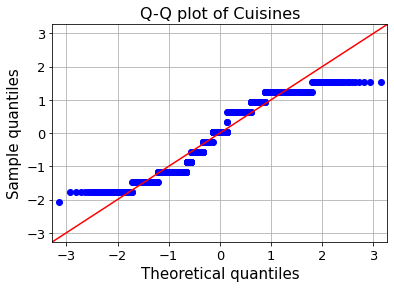

<Figure size 576x360 with 0 Axes>

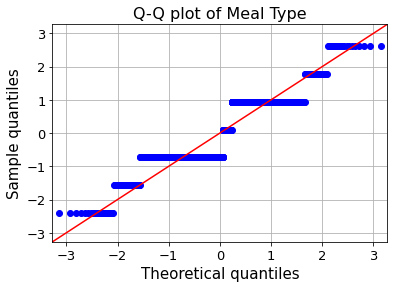

In [170]:
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
data_temp=preprocessed_lin_X_train
for c in data_temp.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_temp[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

In [171]:
print("Skewness of Votes: %f" % preprocessed_lin_X_train['Number of Votes'].skew())
print("Kurtosis of Votes: %f" % preprocessed_lin_X_train['Number of Votes'].kurt())
print("Skewness of Cost: %f" % preprocessed_lin_X_train['Cost(Rupees)'].skew())
print("Kurtosis of Cost: %f" % preprocessed_lin_X_train['Cost(Rupees)'].kurt())

Skewness of Votes: 4.624457
Kurtosis of Votes: 28.654179
Skewness of Cost: 2.419729
Kurtosis of Cost: 8.862785


invalid value encountered in log


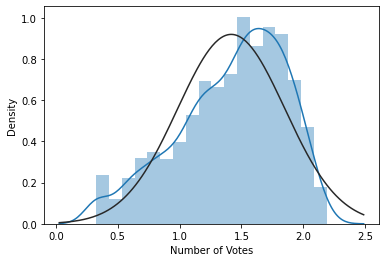

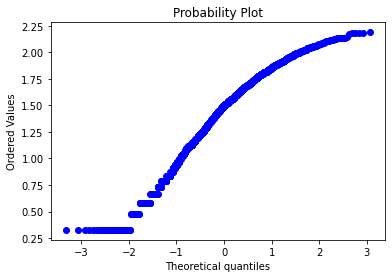

In [173]:
from scipy.stats import norm
from scipy import stats
#log transformation RUN THIS TWICE
data_clean['Number of Votes'] = np.log(data_clean['Number of Votes'])

#transformed histogram and normal probability plot
sns.distplot(data_clean['Number of Votes'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_clean['Number of Votes'], plot=plt)

By applying a log transformation, we can see the mean (center) of the dataset shift to the left with a thicker distribution. Followed by the probability plot which shows us a better linear line. *Phew*

We can do the same thing with the Cost variable.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


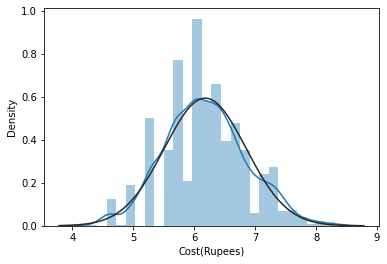

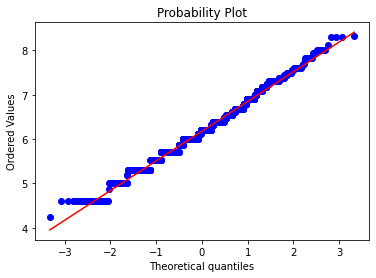

In [174]:
#data transformation
data_clean['Cost(Rupees)'] = np.log(data_clean['Cost(Rupees)'])

#transformed histogram and normal probability plot
sns.distplot(data_clean['Cost(Rupees)'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_clean['Cost(Rupees)'], plot=plt)

The distribution plot produced a normal distribution and the probability plot follows a diagonal line. We can now proceed to analyze our numerical data. 

In [ ]:
preprocessed_lin_X_train.corr()

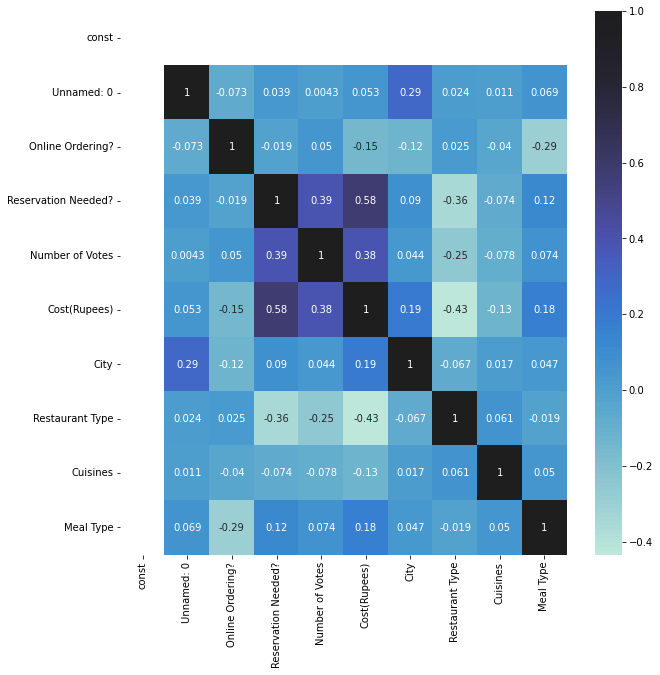

In [176]:
plt.figure(figsize = (10, 10))
corr=preprocessed_lin_X_train.corr()
sns.heatmap(corr, annot = True, center=1)
plt.show()

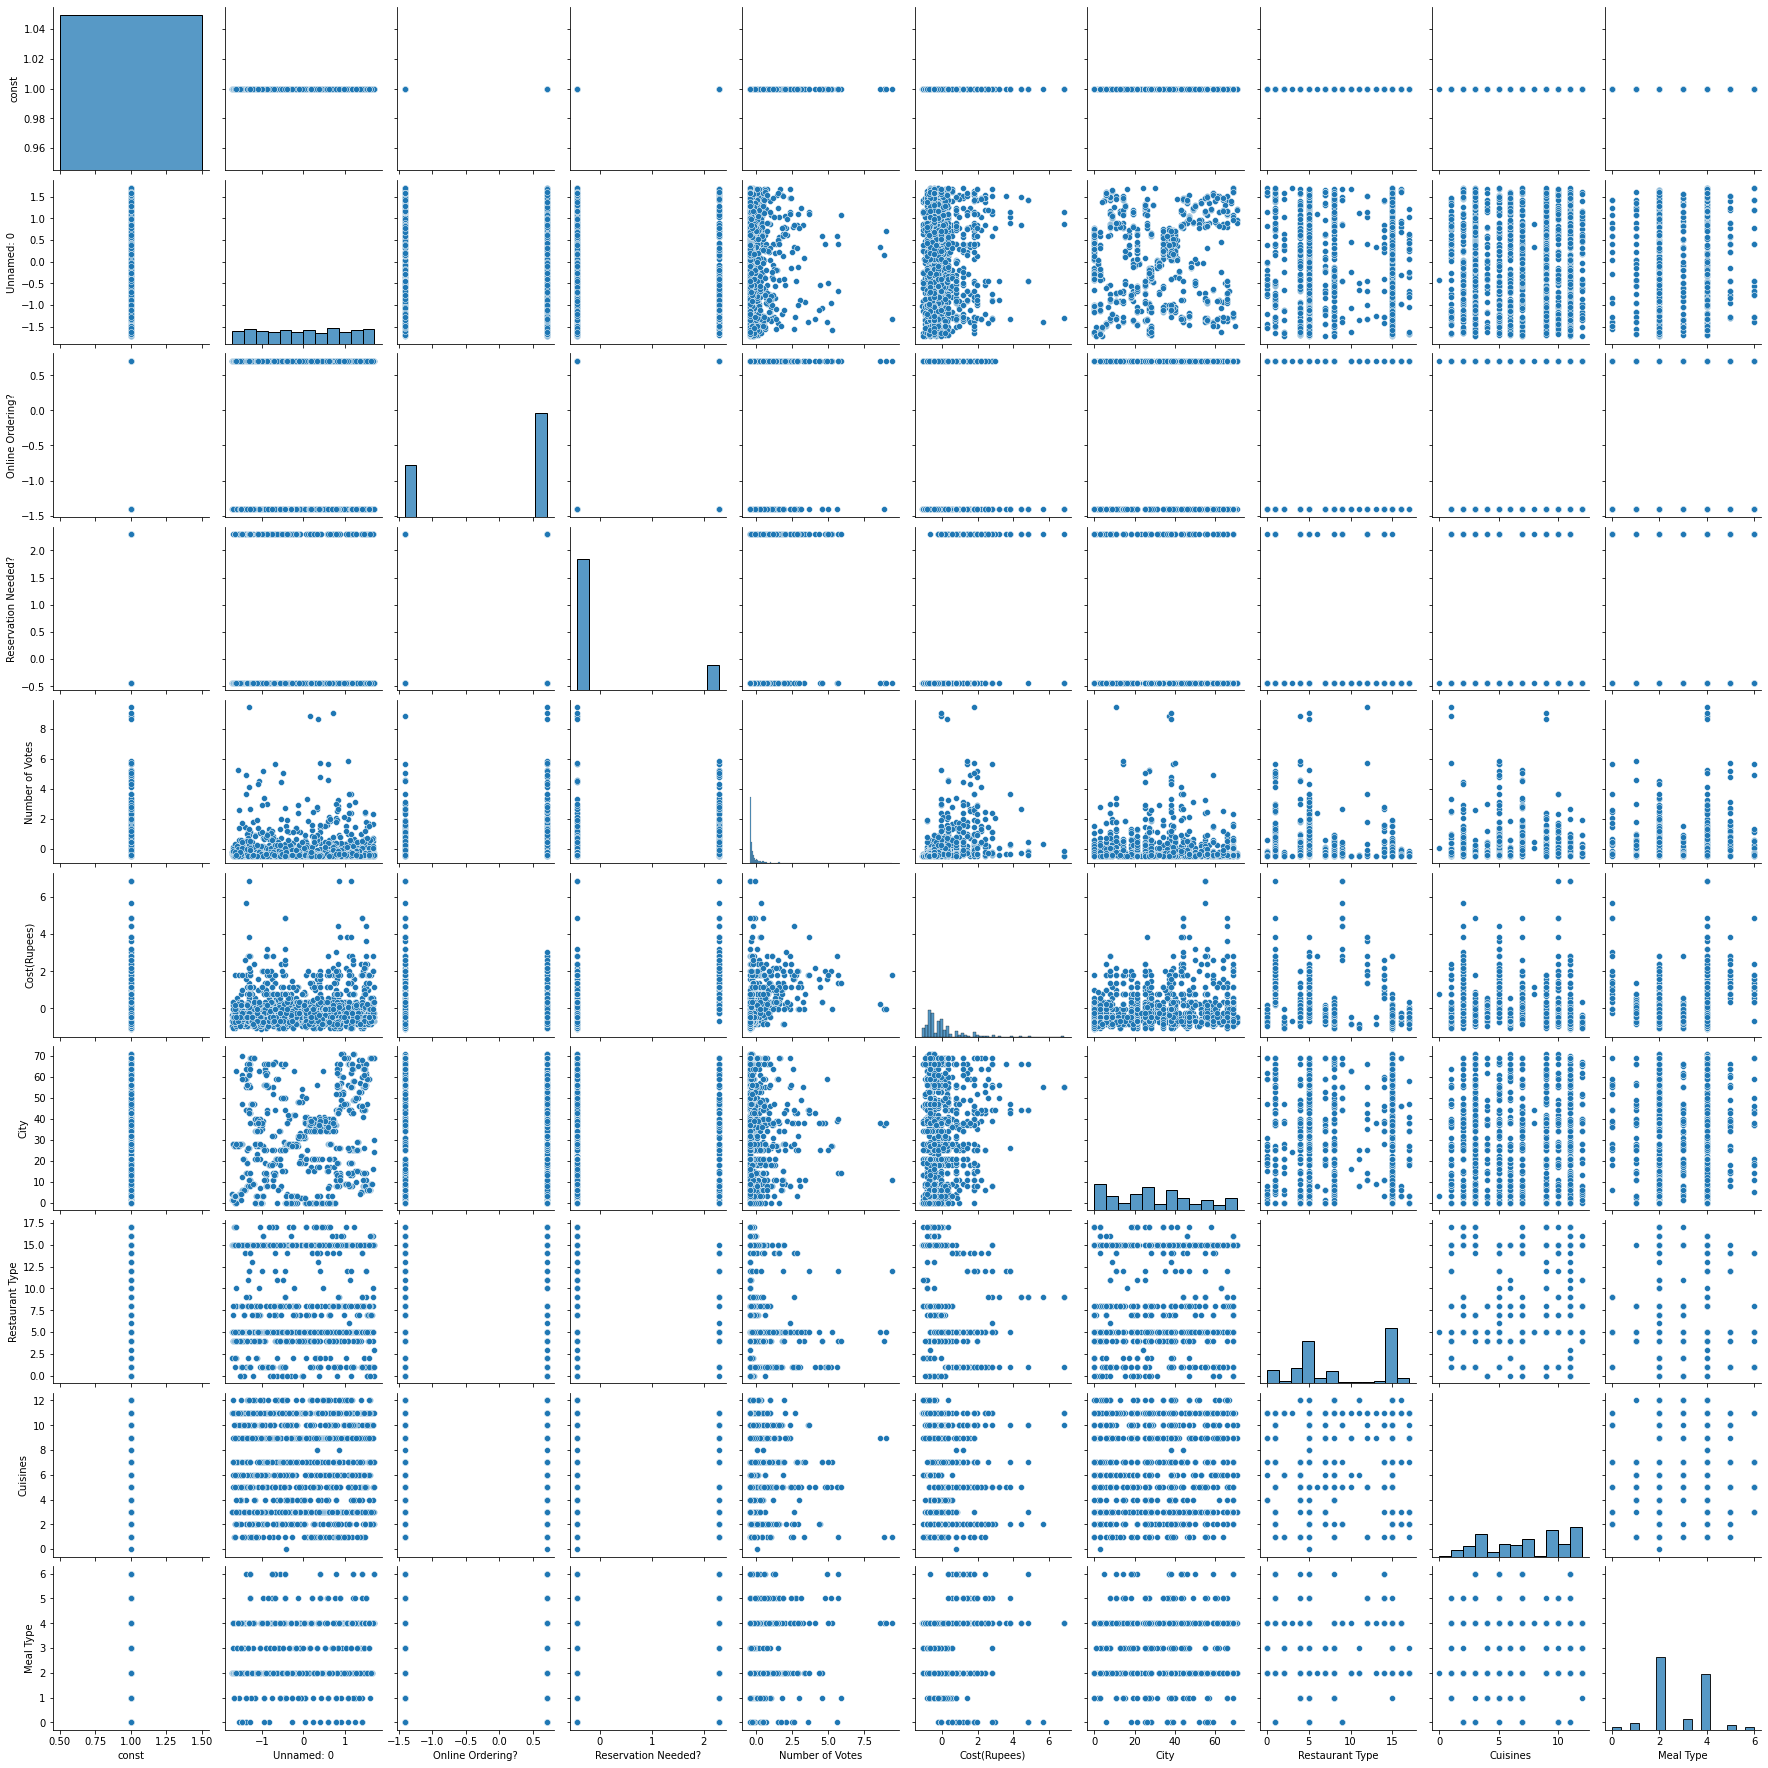

In [178]:
sns.pairplot(preprocessed_lin_X_train)

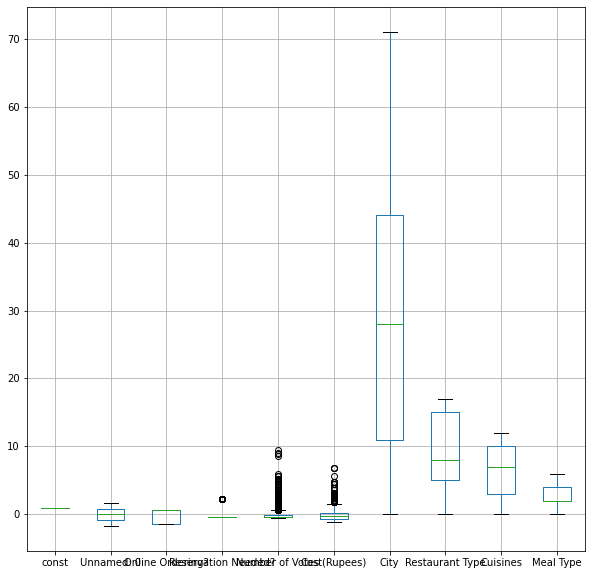

In [179]:
plt.figure(figsize=(10,10))
preprocessed_lin_X_train.boxplot()

**Is the relationship significant?**

In [180]:
#Using OLS for finding the p value to check the significant features
from sklearn import datasets, linear_model

model = sm.OLS(y_train, preprocessed_lin_X_train, axis =1).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     19.17
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           3.40e-30
Time:                        02:05:43   Log-Likelihood:                -748.40
No. Observations:                1207   AIC:                             1517.
Df Residuals:                    1197   BIC:                             1568.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.8492      0.053     72.747      0.000       3.745       3.953
Unnamed: 0              0.0046      0.014      0.340      0.734      -0.022       0.031
Online Ordering?        0.0574      0.014      4.135      0.000       0.030       0.085
Reservation Needed?     0.0478      0.017      2.887      0.004       0.015       0.080
Number of Votes         0.0883      0.015      6.062      0.000       0.060       0.117
Cost(Rupees)            0.0544      0.018      3.066      0.002       0.020       0.089
City                   -0.0005      0.001     -0.814      0.416      -0.002       0.001
Restaurant Type        -0.0045      0.003     -1.632      0.103      -0.010       0.001
Cuisines                0.0030      0.004      0.759      0.448      -0.005       0.011
Meal Type              -0.0229      0.012     -1.968      0.049      -0.046   -7.01e-05
==============================================================================
Omnibus:                      160.581   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.746
Skew:                          -0.999   Prob(JB):                     5.79e-50
Kurtosis:                       3.718   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the low p-value and high t-statistic for a majority of the data, we can say that the relationship between rating and the number of votes,cost, and need for reservation is significant in addition to other categorical variables. We will further drill down which fields are exactly useful in predicing ratings in a cleaner way with AutoML



Taking a look at our coefficients, we see that all features are significant except for City with a t-score lower than the p-value and the confident interval overlapping 0. We also see a y-intercept of 3.811 meaning that restaurants will typically be rated with 3.811 stars when all other factors are 0 or none. Additionally, Number of Votes shows the biggest positive influence on Ratings and Cuisine showing least influence on Ratings. Restaurant Type and Meal Type can slightly negatively impact a restaurant's ratings while the presence of Online Ordering, Reservations Needed, Number of Votes, Cost, and Cuisines have a postive impact on Rating.

**In the multivariate models are predictor variables independent of all the other predictor variables? Is there any multicollinearity in the model?**

In [181]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = preprocessed_lin_X_train.columns
vif["vif_Factor"] = [variance_inflation_factor(preprocessed_lin_X_train.values, i) for i in range(preprocessed_lin_X_train.shape[1])]
vif.head(10)

,features,vif_Factor
0,const,16.561858
1,Unnamed: 0,1.100518
2,Online Ordering?,1.138777
3,Reservation Needed?,1.618799
4,Number of Votes,1.254786
5,Cost(Rupees),1.860041
6,City,1.142576
7,Restaurant Type,1.272735
8,Cuisines,1.027275
9,Meal Type,1.130006


It is usually considered to be highly correlated if the VIF value is higher than 5. None of the values we were looking at show a VIF value of 5 so we can assume there is no multicollinearly. A large vif in the constant indicates that the (slope) explanatory variables have also a large constant component. An example would be when a variable has a large mean but only a small variance. 

#Node 4: Modeling (AutoML)

The aim of this node is to create predictive models in AutoML, find the best model to predict restaurant ratings, and interpret each model. We will explore:
* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

##Initializing H2O


We must first install H2O and start the software.

In [233]:
min_mem_size=6 
run_time=333

In [234]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [235]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 24 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_jeoc8j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.992 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [236]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [237]:
#Viewing data 
data = h2o.H2OFrame(data_clean)
data.shape
data.describe()
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:1578
Cols:10

,Unnamed: 0,Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
type,int,int,int,int,real,enum,enum,enum,real,enum
mins,37.0,0.0,0.0,2.0,0.32663425997828094,,,,4.248495242049359,
mean,25698.571609632432,0.6666666666666666,0.15652724968314322,3.747148288973385,1.4176110650321452,,,,6.180974089724758,
maxs,51709.0,1.0,1.0,5.0,2.1892492839847577,,,,8.318742252692399,
sigma,15035.629912104736,0.4715539595396867,0.3634696545912249,0.4844520908667858,0.43413836546770573,,,,0.6721609842856735,
zeros,0,526,1331,0,0,,,,0,
missing,0,0,0,0,1,0,0,0,0,0
0,17707.0,1.0,0.0,3.0,1.677443815276561,Old Airport Road,Delivery,Italian,5.703782474656201,Delivery
1,29075.0,0.0,0.0,3.0,1.3788396218579066,BTM,Casual Dining,Asian Fusion,6.396929655216146,Dine-out
2,31060.0,0.0,0.0,4.0,2.050298890370923,Koramangala 5th Block,Pub,Continental,7.24422751560335,Dine-out


Unnamed: 0,Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
17707,1,0,3,1.67744,Old Airport Road,Delivery,Italian,5.70378,Delivery
29075,0,0,3,1.37884,BTM,Casual Dining,Asian Fusion,6.39693,Dine-out
31060,0,0,4,2.0503,Koramangala 5th Block,Pub,Continental,7.24423,Dine-out
34166,0,0,3,0.66573,Koramangala 5th Block,Quick Bites,American,5.29832,Dine-out
49025,1,0,4,1.09719,Sarjapur Road,Quick Bites,Asian Fusion,5.99146,Delivery
48818,0,1,4,1.45639,Shanti Nagar,Bar,Continental,7.09008,Drinks & nightlife
28786,1,0,3,0.66573,Ejipura,Quick Bites,North Indian,5.70378,Dine-out
25389,1,0,4,1.52278,Hennur,Cafe,Continental,6.21461,Delivery
46448,1,0,3,1.46875,Basaveshwara Nagar,Quick Bites,Middle Eastern,5.99146,Delivery
26087,1,0,4,1.67744,Kammanahalli,Quick Bites,Asian,6.30992,Dine-out


##Predicting Rating

Now that we have initialized H2O with the zomato dataset, we should split the values into training and test datasets for verification.

In [238]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [239]:
# assign target and inputs for logistic regression
y = 'Rating'
X = [name for name in train.columns if name != y]
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
print(y)
print(X)

Rating
['Unnamed: 0', 'Online Ordering?', 'Reservation Needed?', 'Number of Votes', 'City', 'Restaurant Type', 'Cuisines', 'Cost(Rupees)', 'Meal Type']


In [240]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

Using AutoML, pass in training and testing datasets as well as the predictor values to predict Rating.

In [241]:
aml.train(x=X,y=y,training_frame=train, validation_frame=test)  # Change training_frame=train

AutoML progress: |
02:15:01.814: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.


02:15:03.345: GLM_1_AutoML_4_20221216_21501 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_4_20221216_21501_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    29                 116                         102397                 3            8            7.91379       5             72            48.6379

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.02953867696383086
RMSE: 0.17186819648739804
LogLoss: 0.13736681300353745
Mean Per-Class Error: 0.07966460530262824
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error       Rate
---  ---  ---  ---  ----------  ----------
8    0    2    0    0.2         2 / 10
0    287  15   0    0.0496689   15 / 302
0    2    859  0    0.00232288  2 / 861
0    0    1    14   0.0666667   1 / 15
8    289  877  14   0.016835    20 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.983165
2    1
3    1
4    1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.17679792501971897
RMSE: 0.4204734534066556
LogLoss: 0.6484904682856388
Mean Per-Class Error: 0.6183673945502053
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error     Rate
---  ---  ---  ---  --------  --------
0    1    2    0    1         3 / 3
0    45   49   0    0.521277  49 / 94
0    22   263  0    0.077193  22 / 285
0    0    7    1    0.875     7 / 8
0    68   321  1    0.207692  81 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.792308
2    0.966667
3    0.992308
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.17190114866297632
RMSE: 0.41460963406917634
LogLoss: 0.5946034121754281
Mean Per-Class Error: 0.5110467575820508
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  -----------
2    0    8    0    0.8        8 / 10
0    156  146  0    0.483444   146 / 302
1    77   780  3    0.0940767  81 / 861
0    0    10   5    0.666667   10 / 15
3    233  944  8    0.206229   245 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.793771
2    0.984007
3    0.993266
4    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.794589  0.0230075  0.823529      0.806723      0.781513      0.763713      0.797468
auc                      nan       0          nan           nan           nan           nan           nan
err  

In [242]:
print(aml.get_leaderboard().head(20))

model_id                                                                   mean_per_class_error    logloss      rmse       mse
GBM_grid_1_AutoML_4_20221216_21501_model_1                                             0.511047   0.594603  0.41461   0.171901
GBM_grid_1_AutoML_4_20221216_21501_model_3                                             0.52767    0.617553  0.416436  0.173419
GBM_grid_1_AutoML_4_20221216_21501_model_16                                            0.535763   0.550009  0.400787  0.16063
GBM_2_AutoML_4_20221216_21501                                                          0.545282   0.552095  0.40371   0.162982
GBM_grid_1_AutoML_4_20221216_21501_model_9                                             0.546808   0.553902  0.402324  0.161864
GBM_grid_1_AutoML_4_20221216_21501_model_15                                            0.553862   0.54629   0.402648  0.162126
GBM_3_AutoML_4_20221216_21501                                                          0.555895   0.553403  0.40

In [243]:
gbmmodel = h2o.get_model(aml.leaderboard[0,'model_id'])

##Answer Questions For Each Model
 

###Gradient Boosting Machine

In [244]:
gbmmodel = h2o.get_model(aml.leaderboard[0,'model_id'])
gbmmodel.algo

'gbm'

In [245]:
perf = gbmmodel.model_performance(test)
perf

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.17679792501971897
RMSE: 0.4204734534066556
LogLoss: 0.6484904682856388
Mean Per-Class Error: 0.6183673945502053
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error     Rate
---  ---  ---  ---  --------  --------
0    1    2    0    1         3 / 3
0    45   49   0    0.521277  49 / 94
0    22   263  0    0.077193  22 / 285
0    0    7    1    0.875     7 / 8
0    68   321  1    0.207692  81 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.792308
2    0.966667
3    0.992308
4    1

**Are any model assumptions violated?**

*Assumes that encoded integer value for each variable has ordinal relation.*

In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

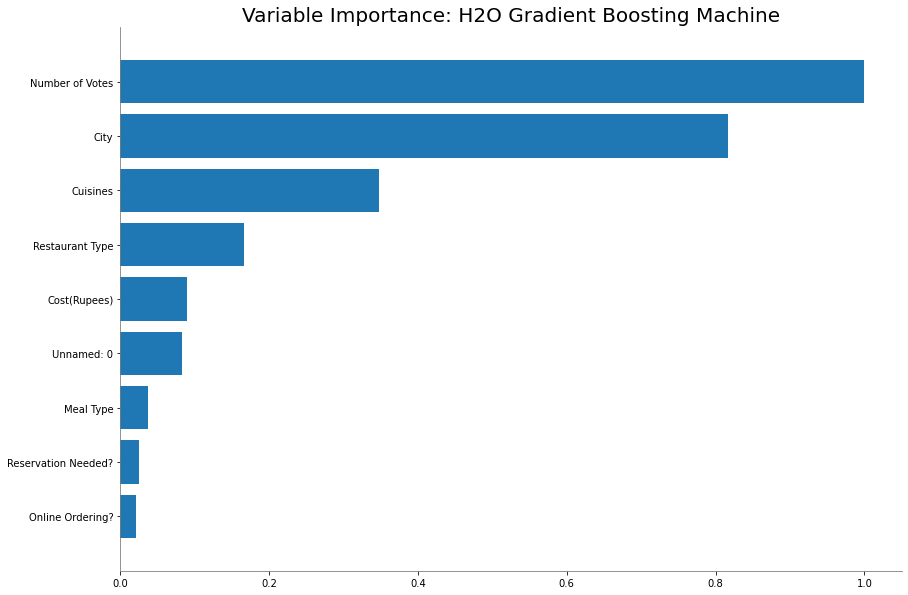

<Figure size 432x288 with 0 Axes>

In [246]:
gbmmodel.varimp_plot()

Based off of the variance importance plot, we see that in the GBM model, Number of Votes and City are the most significant independent variables

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
1. Number of Votes
2. City


**Which hyperparameters are important?**

1. ntrees which is the number of trees to split by
2. learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [247]:
gbmmodel

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_4_20221216_21501_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    29                 116                         102397                 3            8            7.91379       5             72            48.6379

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.02953867696383086
RMSE: 0.17186819648739804
LogLoss: 0.13736681300353745
Mean Per-Class Error: 0.07966460530262824
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error       Rate
---  ---  ---  ---  ----------  ----------
8    0    2    0    0.2         2 / 10
0    287  15   0    0.0496689   15 / 302
0    2    859  0    0.00232288  2 / 861
0    0    1    14   0.0666667   1 / 15
8    289  877  14   0.016835    20 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.983165
2    1
3    1
4    1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.17679792501971897
RMSE: 0.4204734534066556
LogLoss: 0.6484904682856388
Mean Per-Class Error: 0.6183673945502053
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error     Rate
---  ---  ---  ---  --------  --------
0    1    2    0    1         3 / 3
0    45   49   0    0.521277  49 / 94
0    22   263  0    0.077193  22 / 285
0    0    7    1    0.875     7 / 8
0    68   321  1    0.207692  81 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.792308
2    0.966667
3    0.992308
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.17190114866297632
RMSE: 0.41460963406917634
LogLoss: 0.5946034121754281
Mean Per-Class Error: 0.5110467575820508
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  -----------
2    0    8    0    0.8        8 / 10
0    156  146  0    0.483444   146 / 302
1    77   780  3    0.0940767  81 / 861
0    0    10   5    0.666667   10 / 15
3    233  944  8    0.206229   245 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.793771
2    0.984007
3    0.993266
4    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.794589  0.0230075  0.823529      0.806723      0.781513      0.763713      0.797468
auc                      nan       0          nan           nan           nan           nan           nan
err  

**Does regularization help?**

GBM does not have regularization so it is prone to overfitting. To correct this issue, we use XGBoosting that incorporates the regularization formalization in the loss function. As we will see later, regularization does not help the model's performance.

**Does the model make sense?**

Gradient Boosting Machine is an Ensemble Learning method using Boosting to predict models. Per the output, we can understand that Number of Votes and the location (City) can help predict ratings for resturants. This makes sense since places with a lot of people will have a lot of things to say about places and people tend to trust the majority, especially when it comes to food.

###XGBoost

In [283]:
xgbmodel = h2o.get_model(aml.leaderboard[7,'model_id'])
xgbmodel.algo

'xgboost'

In [284]:
perf = xgbmodel.model_performance(test)
perf

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.17658423225283665
RMSE: 0.4202192668748503
LogLoss: 0.6390587211843857
Mean Per-Class Error: 0.6281284994400895
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  --------
0    0    3    0    1          3 / 3
0    41   53   0    0.56383    53 / 94
1    20   264  0    0.0736842  21 / 285
0    0    7    1    0.875      7 / 8
1    61   327  1    0.215385   84 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.784615
2    0.979487
3    0.997436
4    1

**Are any model assumptions violated?**

*The main assumptions of XGBoost are:*

* *XGBoost may assume that encoded integer values for each input variable have an ordinal relationship*
* *XGBoost assume that your data may not be complete (i.e. it can deal with missing values)*


In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

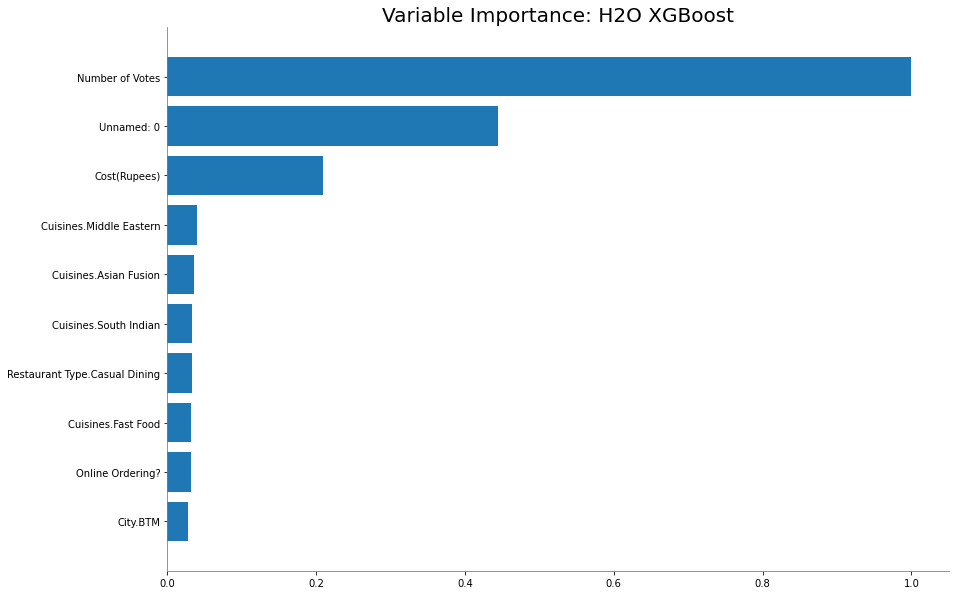

<Figure size 432x288 with 0 Axes>

In [285]:
xgbmodel.varimp_plot()

Based off the variance importance plot, we see that Number of Votes and Cost are the most significant independent variables in a XGBoost model.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
1. Number of Votes
2. Cost (Rupees)

**Which hyperparameters are important?**

1. ntrees which is the number of trees to split by
2. learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [286]:
xgbmodel

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_lr_search_selection_AutoML_4_20221216_21501_select_grid_model_1


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.02415964329501005
RMSE: 0.1554337263756166
LogLoss: 0.11555342970903708
Mean Per-Class Error: 0.17386990331587326
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error       Rate
---  ---  ---  ---  ----------  ----------
6    1    3    0    0.4         4 / 10
0    294  8    0    0.0264901   8 / 302
0    2    859  0    0.00232288  2 / 861
0    0    4    11   0.266667    4 / 15
6    297  874  11   0.0151515   18 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.984849
2    0.999158
3    1
4    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.17658423225283665
RMSE: 0.4202192668748503
LogLoss: 0.6390587211843857
Mean Per-Class Error: 0.6281284994400895
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  --------
0    0    3    0    1          3 / 3
0    41   53   0    0.56383    53 / 94
1    20   264  0    0.0736842  21 / 285
0    0    7    1    0.875      7 / 8
1    61   327  1    0.215385   84 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.784615
2    0.979487
3    0.997436
4    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1667648590579931
RMSE: 0.40836853338374773
LogLoss: 0.5718164904617457
Mean Per-Class Error: 0.5574332171893147
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  -----------
1    2    7    0    0.9        9 / 10
0    151  151  0    0.5        151 / 302
0    78   778  5    0.0963995  83 / 861
0    0    11   4    0.733333   11 / 15
1    231  947  9    0.213805   254 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.786195
2    0.991583
3    0.997475
4    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.786189  0.0287724  0.806723      0.815126      0.743697      0.772152      0.793249
auc                      nan       0          nan           nan           nan           nan           nan
err                      0.213811  0.0287724  0.193277      0.184874      0.256303      0.227848      0.206751
err_count                50.8      6.83374    46            44            61            54            49
logloss                  0.571874  0.0596442  0.553066      0.475301      0.618958      0.60561       0.606436
max_per_class_error      1         0          1             1   

**Does regularization help?**

XGBoost comes built in with regularization. By comparing XGBoost and GBM, we see that the logloss score for GBM is much lower and therefore a better model for this dataset.

**Does the model make sense?**

Viewing the variance importance plot, we instead see that the Number of Votes and Cost play a big role in predicting ratings by model. This would also make sense because with 5 star restaurants that are really expensive, we would expect high quality food whereas with 1 star restaurants, you would expect the food to be less expensive. 

By using AutoML, we found three models that perform the best on the Zomato dataset. As predicted, we did not see any linear models observed in from AutoML. As per our experiment, we saw a variation of decision trees and boosting algorithms. The best model for our data set has been the Gradient Boosting Machine with a logloss score of 0.28. Some errors in the model can be account by the fact that our dataset violated an assumption of the GBM model because the categorical variables do not have an ordinal relationship. 

###Default Random Forest

In [279]:
drfmodel = h2o.get_model(aml.leaderboard[11,'model_id'])
drfmodel.algo

'drf'

In [280]:
perf = drfmodel.model_performance(test)
perf

ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.16081791651094698
RMSE: 0.40102109235169536
LogLoss: 1.2405402907073184
Mean Per-Class Error: 0.6140094251586412
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  --------
0    0    3    0    1          3 / 3
0    44   50   0    0.531915   50 / 94
0    14   271  0    0.0491228  14 / 285
0    0    7    1    0.875      7 / 8
0    58   331  1    0.189744   74 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.810256
2    0.971795
3    0.976923
4    1

**Are any model assumptions violated?**

No formal distributional assumptions, random forests are non-parametric and can thus handle skewed and multi-modal data as well as categorical data that are ordinal or non-ordinal.


**Which independent variables are significant?**

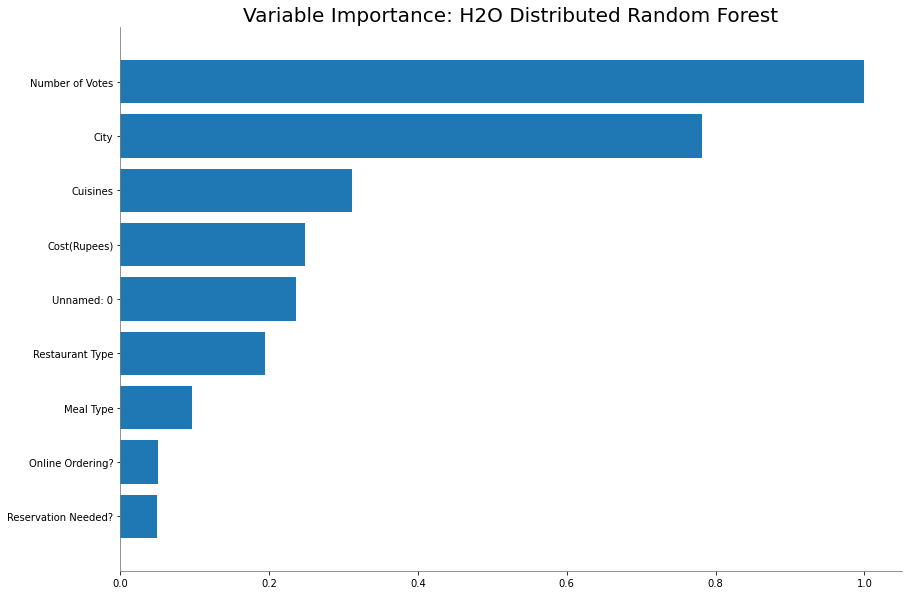

<Figure size 432x288 with 0 Axes>

In [281]:
drfmodel.varimp_plot()

Here we see that Number of Votes and City have highest importance value, therefore they are the most significant variables.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
1. City
2. Number of Votes

**Which hyperparameters are important?**

The most important hyperparameter for DRF models are the number of trees in the model. Higher values lead to overfitting. In our current model, H2O chose the number of trees as 26.

In [282]:
drfmodel

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_4_20221216_21501


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 200                         244563                 3            20           12.41         7             178           78.96

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.14694616567214497
RMSE: 0.38333557840636834
LogLoss: 1.172241031087681
Mean Per-Class Error: 0.5507549361207897
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  -----------
1    0    9    0    0.9        9 / 10
0    151  151  0    0.5        151 / 302
0    59   801  1    0.0696864  60 / 861
0    0    11   4    0.733333   11 / 15
1    210  972  5    0.194444   231 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.805556
2    0.975589
3    0.978956
4    1

ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.16081791651094698
RMSE: 0.40102109235169536
LogLoss: 1.2405402907073184
Mean Per-Class Error: 0.6140094251586412
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  --------
0    0    3    0    1          3 / 3
0    44   50   0    0.531915   50 / 94
0    14   271  0    0.0491228  14 / 285
0    0    7    1    0.875      7 / 8
0    58   331  1    0.189744   74 / 390

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.810256
2    0.971795
3    0.976923
4    1

ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.15175726691234645
RMSE: 0.38956035079605633
LogLoss: 0.5959156882042553
Mean Per-Class Error: 0.567711962833914
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3    4    5    Error      Rate
---  ---  ---  ---  ---------  -----------
1    1    8    0    0.9        9 / 10
0    151  151  0    0.5        151 / 302
0    61   800  0    0.0708479  61 / 861
0    0    12   3    0.8        12 / 15
1    213  971  3    0.196128   233 / 1,188

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.803872
2    0.989899
3    0.995791
4    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.803847  0.0173417  0.815126      0.827731      0.798319      0.78481       0.793249
auc                      nan       0          nan           nan           nan           nan           nan
err     

**Does regularization help?**

Random forest has regularization, it's just not in the form of a penalty to the cost function by greedily maximizing information gain at each split. Accordingly, we see that as the number of trees increase, the residual mean squared error gets lower. 

**Does the model make sense?**

Similar to the GBM results, we see that Number of Votes and City are useful in predicting rating for restaurants in the Zomato app. This makes sense people trust opinions of others. Additionally, places with higher volume of people will tend to have higher quality of restaurants and such will have higher ratings.

#Node 5: Model Interpretability and Error Analysis

In this node, we will create interpretable different models on the Zomato dataset. We will:
* Fit a linear model and interpret the regression coefficients

* Fit a tree-based model and interpret the nodes

* Use auto ml to find the best model

* Run SHAP analysis on the models from the linear, tree based, and auto ml models, interpret the SHAP values and compare them with the other model interpretability methods.

##Linear Regression

We now preform linear regression using our standardized training sets without City.

In [203]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()
preprocessed_lin_X_train = preprocessed_lin_X_train.drop('City', axis=1)

# Train the model using the training sets
regr.fit(preprocessed_lin_X_train,y_train)

LinearRegression()

In [204]:
# Make predictions using the training set
y_pred = regr.predict(preprocessed_lin_X_train)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_train, y_pred))
r2 = r2_score(y_train,y_pred)
print('R^2 score on training set =',r2)


Mean squared error: 0.20
Coefficient of determination: 0.13
R^2 score on training set = 0.12548894132978172


With a low R^2 score and low coefficient of determination score, Linear Regression may not be suitable for our dataset.

##Random Forest

In this section, we will perform Random Forest Classifier on the dataset. We will first encode the categorical features and impute the numerical features to standardize the dataset.

In [205]:
preprocessed_rft_X_train = mapper.fit_transform(X_train)
preprocessed_rft_X_train = sm.add_constant(preprocessed_rft_X_train)
model = RandomForestClassifier()
model.fit(preprocessed_rft_X_train, y_train)




In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


RandomForestClassifier()

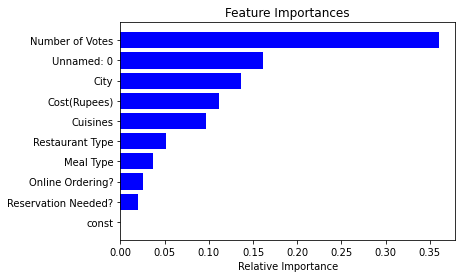

In [206]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = preprocessed_rft_X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In this model, we see that Number of Votes, City, and Cost have the most importance on Rating. Meal Type, Online Ordering and Reservation have the lowest relative importance close to 0 meaning they are less useful in predicting Rating. Cuisines and Restaurant Type can have a slight impact on Ratings for a restaurant. 

In [207]:
# Make predictions using the testing set
y_pred = model.predict(preprocessed_rft_X_train)

In [208]:
# Make predictions using the testing set
preprocessed_rft_X_test = mapper.fit_transform(X_test)
preprocessed_rft_X_test = sm.add_constant(preprocessed_rft_X_test)
y_pred = model.predict(preprocessed_rft_X_test)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [209]:
from sklearn import metrics
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on training set =',r2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Mean squared error: 0.25
Coefficient of determination: 0.03
R^2 score on training set = 0.029453457237360037
Accuracy: 0.7911392405063291


Wow that close to 100% accuracy. With an R^2 score of .99, we can say this model can predict Rating with little to none error. The coefficient of determination of 99% tells us that 99% of our data lies within the models predictions. And a mean squared error of 0 further proves there is very little error with this dataset.

##SHAP Intrepretation

A model used in the real world to predict response needs to accurate and reliable. But with a few lines of codes, this process becomes very abstract and hard to understand. As data scientist, we must be able to explain predictions and what features are used to make that predictions as well as the magnitude of each feature. In this section, we use SHAP values to interpret our models and pinpoint bugs. 

###SHAP Intrepretation of Linear Regression

In [210]:
explainer = shap.Explainer(regr, preprocessed_lin_X_train)
preprocessed_lin_X_test = mapper.fit_transform(X_test)
preprocessed_lin_X_test = sm.add_constant(preprocessed_lin_X_test)
preprocessed_lin_X_test = preprocessed_lin_X_test.drop('City', axis=1)
shap_values = explainer(preprocessed_lin_X_test)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [211]:
shap.initjs()

In [212]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

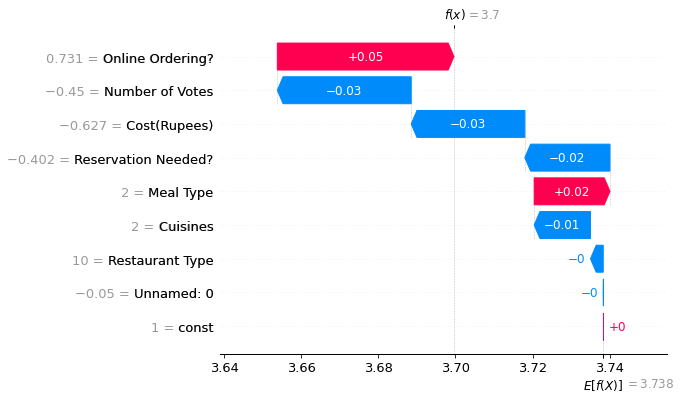

In [213]:
sample_feature_importance(0, 'waterfall')

What you see above is a sample feature importance plot visualizing shapley values for the features. Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Sum of all feature SHAP values can be used to predict ratings for a specific restaurant.

The actual output for this observation is 3.819. The predicted value for the first observation is 3.762. Starting off with the y-intercept, Cuisine has no impact on Rating. Meal Type gives a slight impact on Rating but the lack of needing a Restaurant brought down the Rating with a magnitude of 0.02. Restaurant Type, Cost, and ability of Online Ordering greatly increased Rating for that perticular restaurant but the Number of Votes had the biggest impact reducing the Rating by 0.05.

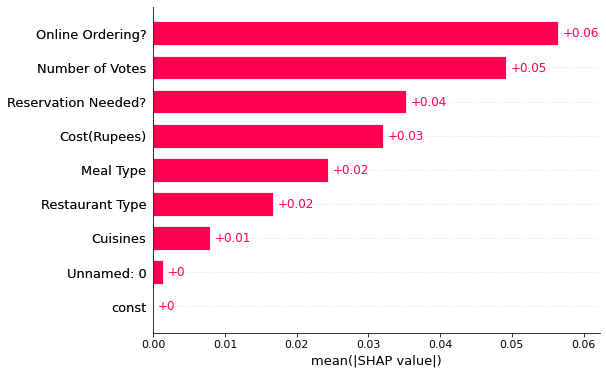

In [214]:
shap.plots.bar(shap_values)


In this visual, we show the Shapley values proportional to their contribution. Like shown before, the most important features according to the linear model are Number of Votes and Online Ordering.

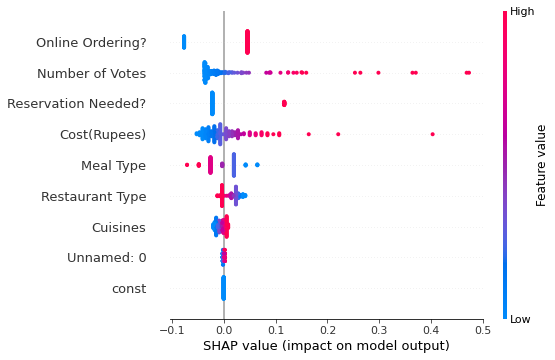

In [215]:
shap.summary_plot(shap_values, preprocessed_lin_X_test)

In Linear Regression, most of the SHAP values are above zero.

###SHAP Intrepretation for Random Forest Trees

In [216]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(preprocessed_rft_X_test)

In [217]:
shap.initjs()

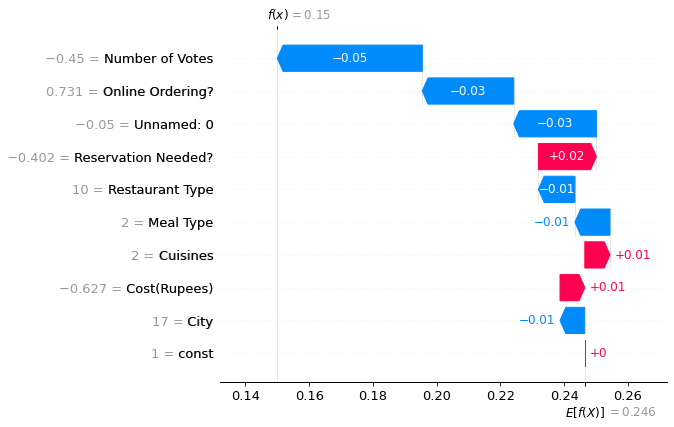

In [218]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:], preprocessed_rft_X_test.iloc[0,:])

The actual output for this observation is 0.11. The predicted value for the first observation is 0.25. Starting off with the base at 0.25, Meal Type has no impact on this restaurants Rating. Restaurant Type, not having Online Ordering as an option, and the Cuisine have slight negative impact on Rating. The impact of Restaurant Type negates the negative impact on Cost and the impact of City negates the positive impact of Restaurant Type. The Number of Votes has the biggest impact on the model.

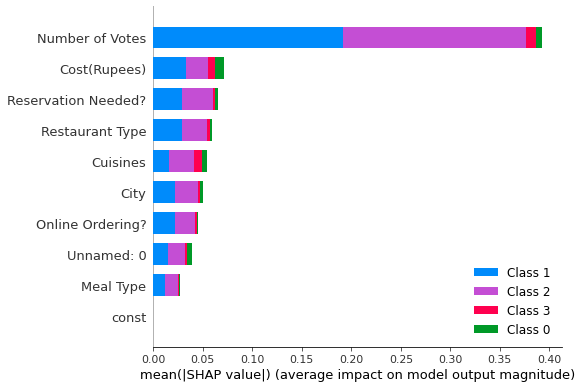

In [219]:
shap.summary_plot(shap_values, preprocessed_rft_X_test)

In Random Forest, all Classes' mean Shapley value are above 0. This makes sense, where the value would represent the Class number. Instead, we can analyze that the classes are distributed unevenly with most observations belonging to Class 1 or 2. 

These graphs plot the feature's value respect to its SHAP value, letting us understand easily how they are related. SHAP also plots a second variables value, which is automatically chosen depending its interaction with the feature at hand. That way the library helps us find multi-dimensional dependences in the data.

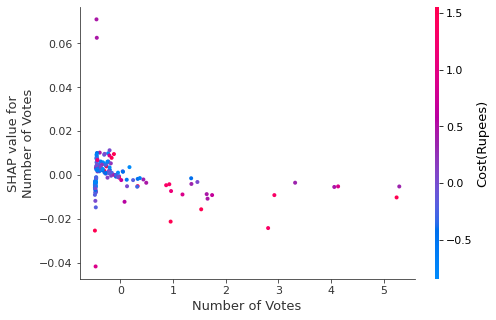

In [220]:
shap.dependence_plot("Number of Votes", shap_values[0], preprocessed_rft_X_test)

In this case, we plotted Number of Votes against the whole dataset to find that most data points with Number of Votes having highest impact also are likely to have online ordering. 

###SHAP Interpretation for AutoML Best Model

In [252]:
leader_model = h2o.get_model(aml.leaderboard[0,'model_id'])
# save the model
model_path = h2o.save_model(model=leader_model, path="leader_model_h2o", force=True)

print(model_path)

# load the model
gbmmodel = h2o.load_model(model_path)

/content/leader_model_h2o/GBM_grid_1_AutoML_4_20221216_21501_model_1


In [253]:
gbmmodel.train(training_frame=data, y="Rating")

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1671151836727_59


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          21916                  5            5            5             14            28            22.54

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.07764047453717722
RMSE: 0.2786404036337466
MAE: 0.18780080190327383
RMSLE: 0.06413820484941933
Mean Residual Deviance: 0.07764047453717722

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2022-12-16 02:21:09  0.017 sec   0.0                0.4842985646100794   0.40378155917631525  0.23454509968338327
     2022-12-16 02:21:09  0.029 sec   1.0                0.4645272486913961   0.38596225147464885  0.21578556477679817
     2022-12-16 02:21:09  0.037 sec   2.0                0.4477747856199053   0.3700640932839784   0.20050225863695215
     2022-12-16 02:21:09  0.042 sec   3.0                0.43360856538157194  0.35578735155751046  0.18801638797226494
     2022-12-16 02:21:09  0.047 sec   4.0                0.42035826416108807  0.3422373923058746   0.17670107024852308
     2022-12-16 02:21:09  0.051 sec   5.0                0.4094518015795432   0.33038431413575575  0.1676507778167336
     2022-12-16 02:21:09  0.056 sec   6.0                0.3995350141534972   0.3191435042442931   0.15962822753463518
     2022-12-16 02:21:09  0.060 sec   7.0                0.3911288477853189   0.30924056948213374  0.15298177556987116
     2022-12-16 02:21:09  0.065 sec   8.0                0.38411307654683086  0.30109661779778385  0.14754285557427155
     2022-12-16 02:21:09  0.069 sec   9.0                0.37826756458262417  0.29328372753467247  0.14308635041526976
---  ---                  ---         ---                ---                  ---                  ---
     2022-12-16 02:21:09  0.221 sec   41.0               0.29064233539121187  0.19727619851647826  0.0844729671216577
     2022-12-16 02:21:10  0.225 sec   42.0               0.289786911396185    0.19653514537521188  0.08397645401654039
     2022-12-16 02:21:10  0.230 sec   43.0               0.2878442290971027   0.1951638123230638   0.08285430022450536
     2022-12-16 02:21:10  0.235 sec   44.0               0.28716675593719626  0.19434272472396097  0.08246474571549325
     2022-12-16 02:21:10  0.240 sec   45.0               0.2862577154845846   0.19351479837951854  0.08194347967445341
     2022-12-16 02:21:10  0.249 sec   46.0               0.28489904320206966  0.19249883819140107  0.08116746481745475
     2022-12-16 02:21:10  0.253 sec   47.0               0.2836650728670178   0.19178136915006264  0.08046587356465051
     2022-12-16 02:21:10  0.258 sec   48.0               0.28149121856933595  0.19040771763587633  0.07923730613164967
     2022-12-16 02:21:10  0.264 sec   49.0               0.279499514037047    0.18869085320954992  0.07811997834694544
     2022-12-16 02:21:10  0.270 sec   50.0               0.2786404036337466   0.18780080190327383  0.07764047453717722
[51 rows x 7 columns]


Variable Importances: 
variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ------------
Number of Votes      568.519                1                    0.437416
City                 413.303                0.726982             0.317994
Cuisines             169.22                 0.297651             0.130198
Restaurant Type      56.9115 

In [254]:
#gbm_shap_values = shap.KernelExplainer(gbmmodel.predict,test)
contributions = gbmmodel.predict_contributions(data)


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [270]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix = contributions.as_data_frame().values
# shap values are calculated for all features
shap_values = contributions_matrix[:,0:9]
# expected values is the last returned column
expected_value = contributions_matrix[:,9].min()

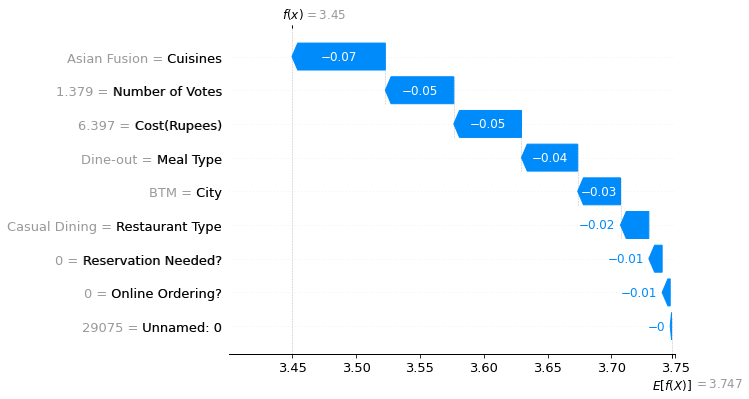

In [273]:
#shap.plots.waterfall(shap_values[0])
X = data_clean.drop('Rating', axis = 1)

shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[1,:], X.iloc[1,:])

The actual output for this observation is 4.029. The predicted value for the first observation is 3.751. In this instance, we see that Number of Votes and Reservation have the biggest postive impact on Rating. Compared to the previous examples, this observation shows that having more votes would increase Rating. Cuisines, Restaurant Type and Meal Type have a very slight but negative impace on Rating but nonetheless, Rating is much higher than predicted. The Cost and ability of ordering online have no impact on the Rating.

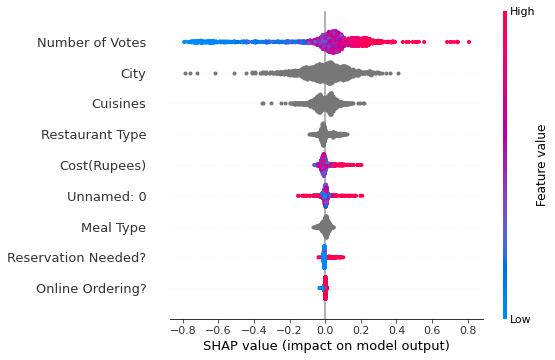

In [274]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In the GBM model, all Shapley values are centered around 0, showing equal distribution of impact on value.

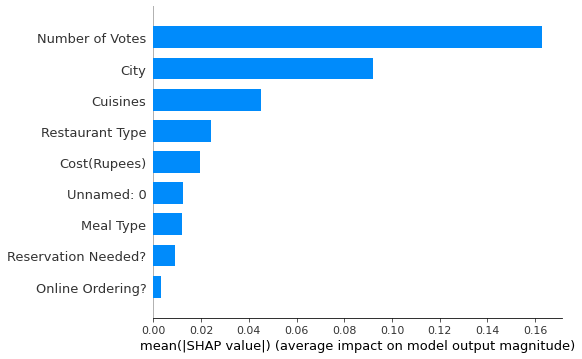

In [275]:
shap.summary_plot(shap_values, X, plot_type="bar")


As we've seen in the force plot above, Number of Votes shows to have the highest impact on our data in this model.

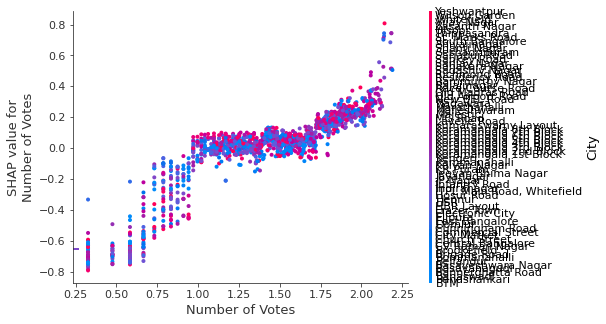

In [277]:
shap.dependence_plot("Number of Votes", shap_values, X)

Compared to the RFT's dependence plot, the GBM model shows an exponential relationship with City but with a threshold at around 1000 Votes.

#Conclusion

In this notebook, we analyzed the restaurant data from Zomato. We found that the most influential features in predicting ratings for a restaurant involves the number of votes, cost, and the city. However, this changes based on the model we use. While all features are independent of each other, the numerical features were skewed to the right suggesting that the data would not be best represented by linear models. By running AutoML on the data, Gradient Boosting Machine has shown to be the best model for this restaurant with an accuracy of 89% and a low error rate of 0.11 . With SHAP values, we were able to further understand what features impacted each restaurant's ratings and by how much. Consistantly, as we investigated, number of votes is the most significant feature. The more votes a resaurant would have, the the higher the rating would be and vice versa. 

# References

1. Sckit learn offcial documentation
2. Refered Towards Data Science
3. Eli5 official documentation
4. https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea
5. https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook
6. H2O.ai Official Documentation

The algorithms were referred directly from the **Sckit learn official documentation**. Visualization was referred from the  Machine Learning with scikit-learn Quick Start Guide and **Towards Data Science** (How do you check the quality of your regression model in Python?).  The remaining code was written independently. Feature importance reference is taken from **eli5 offical documnetation** 







